# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)

using Pkg; Pkg.activate(".")
#Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility
using OrdinaryDiffEq, ComponentArrays, Plots, JLD2, Flux, Random, Statistics, ProgressMeter, StatsBase, ParameterSchedulers, BSON, Optimisers, Optim, Zygote, Printf
using ParameterSchedulers: Stateful
using Flux: Adam

  Activating project at `~/Desktop/Deltares/Final Report Code/Model-2`


In [2]:
#const SEED = rand(UInt) 
const SEED = 6007236083150485430   # surrogate 2 (report 1) - short
Random.seed!(SEED); println("Using seed = $SEED")

# Correction model configuration
global_scale = false                # single α for all stations, false: per-station α
complete_input = true               # use full input or false: reduced (h, u tau, scale)
predict_scale_increment = true      # false to predict absolute scale 
K_increase = false                  # increasing starting from K_global

# Model selection
surrogate = 2           # 1 to 5
correction = 1          # 1 for surrogate 2       

# Correction init data 
wind_name = "periodic"            # periodic only (other unstable)
correction_init_state = "flat"    # flat or bump or small_bump
longer = false                    # true for longer simulation time 

# Surrogate model configuration
predict_increment = true   # false to predict absolute
use_multi_data = true      # several wind amplitudes training 
use_multi_init = false     # several init states training

# Directories
save_dir = "surrogates/surrogate_$(surrogate)/correction_$(correction))"
mkpath(save_dir)

# Training parameters
learning_rate = 1e-5 # 1e-3 # 1e-4 # 5e-4
n_epochs_corr = 5000 # 10000
batch_size = 32

n_hidden_corr = 128 # 32 # 64 # 20 # 128 # 256
activation_corr = swish # relu # swish # tanh # sigmoid

# Model hyperparameters
K_global = 2         # unrolling steps in training 
scale_min = 0.4f0    # scale lower bound
scale_max = 1.8f0    # scale upper bound

@show wind_name, correction_init_state, longer, predict_increment, use_multi_data, global_scale, complete_input
nothing 

Using seed = 6007236083150485430
(wind_name, correction_init_state, longer, predict_increment, use_multi_data, global_scale, complete_input) = ("periodic", "flat", false, true, true, false, true)


#### Setup

In [3]:
const DEBUG = true
const use_gpu = false

function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

to_device(x) = x
if use_gpu
    try
        using CUDA
        println("CUDA is available. Using GPU.")
        CUDA.seed!(SEED)
        to_device(x) = gpu(x)
    catch e
        println("CUDA.jl not found or error loading it. Using CPU. Error: $e")
    end
else
    println("Using CPU.")
end

Using CPU.


In [4]:
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [5]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    H = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        H[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, H, U
end

function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)


q_right (generic function with 1 method)

#### Numerical Simulation and Model Data

In [6]:
# Import surrogate model data 
if longer 
    @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
else 
    @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
end 

for (k, v) in surrogate_data
    eval(:($(Symbol(k)) = $v))
end

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

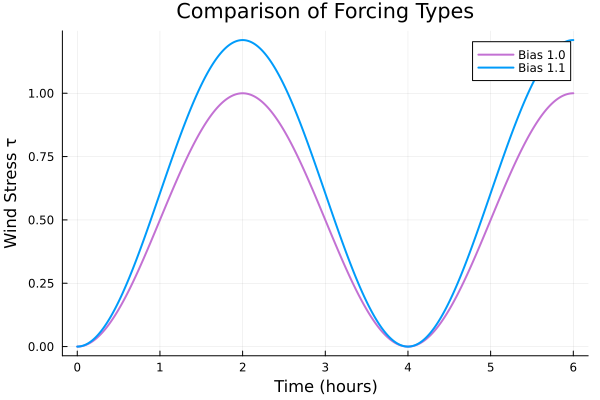

In [7]:
# Create wind stress forcings to compare base vs biased
if wind_name == "AR(2)"
    # Autoregressive process of order 2
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    # Piecewise constant forcing with noise
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    # No wind forcing
    tau_nominal = make_tau_zero() 
    tau_true = make_tau_zero() 

elseif wind_name == "constant"
    # Constant wind stress
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    # Single-frequency periodic forcing
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    # Multi-frequency forcing with weighted components
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    # Default fallback: periodic forcing
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

p = compare_forcings(Dict("Bias 1.0" => tau_nominal,"Bias $bias_factor" => tau_true), times)
display(p)

In [8]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale; n_init_conditions=n_init_conditions)
    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Encode initial condition if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_idx = ic_to_idx[correction_init_state]
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_idx] = 1.0f0
    end

    # Rollout loop over time steps
    for k in 1:(length(times) - 1)
        # Build raw input vector for this step
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Collect local features for each station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if applicable
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize inputs
        input_norm = copy(input_vec)
        input_norm[surrogate_data[:norm_cols_X]] = (input_vec[surrogate_data[:norm_cols_X]] .- mu_X) ./ sigma_X
        input_norm[surrogate_data[:mask_cols_X]] = input_vec[surrogate_data[:mask_cols_X]]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Surrogate prediction
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[surrogate_data[:norm_cols_Y]] = pred_vec[surrogate_data[:norm_cols_Y]] .* sigma_Y .+ mu_Y

        # Update state
        if surrogate_data[:predict_increment]
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred  
end

rollout_surrogate (generic function with 1 method)

### Experiment setup

In [9]:
if longer 
    @load "data/$(correction_init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(correction_init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# Generate 'true' data (observations from the true model)
println("\nGenerating TRUE data (with scale=$bias_factor)...")
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, H_true, U_true = run_model_and_extract(f_true, x0, times, station_idxs)

# Generate surrogate training data 
println("\nGenerating surrogate data (with no scale)...")
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal, H_nominal, U_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)


# Ensure all data are Float32
H_nominal = Float32.(H_nominal)
U_nominal = Float32.(U_nominal)
H_true = Float32.(H_true)  
U_true = Float32.(U_true)
times = Float32.(times)

mu_X = Float32.(mu_X)
sigma_X = Float32.(sigma_X)
mu_Y = Float32.(mu_Y)
sigma_Y = Float32.(sigma_Y)

D_stations = Float32.(D_stations)
mask = Float32.(mask)

nothing


Generating TRUE data (with scale=1.1)...

Generating surrogate data (with no scale)...


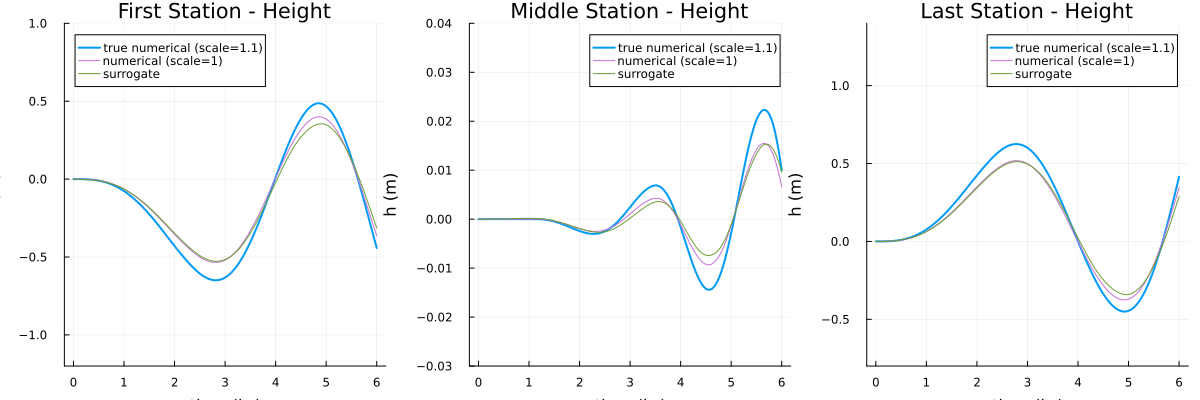

In [10]:
# Original surrogate (no correction)
if use_multi_init
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y,
                                                D_stations, mask, n_stations, 1.0f0)
else
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y,
                                                D_stations, mask, n_stations, 1.0f0, n_init_conditions=nothing)
end 

# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["First Station - Height", "Middle Station - Height", "Last Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

display(plt)
nothing

In [11]:
function build_correction_normalization_cols(complete_input, n_stations, N_LOCAL_FEATURES, use_multi_init; n_init_conditions=nothing)
    # Build normalization and masking column indices for correction model
    norm_cols_corr = Int[]
    mask_cols_corr = Int[]
    
    if complete_input
        # Local features per station
        for i in 1:n_stations
            offset = (i - 1) * N_LOCAL_FEATURES
            append!(norm_cols_corr, [offset + 1, offset + 2, offset + 3, offset + 5])  # h, u, D, tau
            append!(mask_cols_corr, [offset + 4, offset + 6])  # mask, scale
        end
        
        # Add IC encoding columns to mask_cols_corr
        if use_multi_init
            ic_start = N_LOCAL_FEATURES * n_stations + 1
            ic_cols = collect(ic_start:(ic_start + n_init_conditions - 1))
            append!(mask_cols_corr, ic_cols)
            println("✓ Added IC encoding columns to mask_cols_corr: ", ic_cols)
        end
        
        return norm_cols_corr, mask_cols_corr
    else
        # Reduced input case 
        for i in 1:n_stations
            offset = (i - 1) * 4
            append!(norm_cols_corr, [offset + 1, offset + 2, offset + 3])
            append!(mask_cols_corr, [offset + 4])
        end
        return norm_cols_corr, mask_cols_corr
    end
end

if use_multi_init
    norm_cols_corr, mask_cols_corr = build_correction_normalization_cols(complete_input, n_stations, N_LOCAL_FEATURES, use_multi_init, n_init_conditions=n_init_conditions)
else 
    norm_cols_corr, mask_cols_corr = build_correction_normalization_cols(complete_input, n_stations, N_LOCAL_FEATURES, use_multi_init)
end

nothing

In [12]:
# For input normalization
norm_map_X = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_X)
    norm_map_X[col_idx] = stat_idx
end

# For output normalization  
norm_map_Y = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_Y)
    norm_map_Y[col_idx] = stat_idx
end

# For correction input normalization
norm_map_corr = Dict{Int, Int}()
for (stat_idx, col_idx) in enumerate(norm_cols_corr)
    norm_map_corr[col_idx] = stat_idx
end

### Correction Network Architecture

In [13]:
# Correction model 
n_in_corr = complete_input ? n_in : 4 * n_stations   # everything or h, u, tau and scale 
n_out_corr = global_scale ? 1 : n_stations           # correction for tau

corrective_model = Chain(
    Dense(n_in_corr, n_hidden_corr, activation_corr),
    Dense(n_hidden_corr, n_hidden_corr, activation_corr),
    Dense(n_hidden_corr, n_out_corr)
) |> to_device

correction_params = Flux.trainable(corrective_model) |> to_device
debug("Number of parameters in calibration model: $(sum(length, correction_params))")

# Optimizer setup
opt = OptimiserChain(ClipGrad(5.0), Adam(learning_rate))
optimizer_corr = Flux.setup(opt, corrective_model) 

# Learning rate 
decay_rate = 0.99
lr_scheduler = Stateful(Exp(learning_rate, decay_rate))

# Convert to device and Float32
mu_X = Float32.(to_device(mu_X))
sigma_X = Float32.(to_device(sigma_X))
mu_Y = Float32.(to_device(mu_Y))
sigma_Y = Float32.(to_device(sigma_Y))

# Summary
@show wind_name, correction_init_state, longer, predict_increment
@show n_in_corr, n_out_corr, n_hidden_corr, learning_rate, n_epochs_corr
@show corrective_model

Number of parameters in calibration model: 3
(wind_name, correction_init_state, longer, predict_increment) = ("periodic", "flat", false, true)
(n_in_corr, n_out_corr, n_hidden_corr, learning_rate, n_epochs_corr) = (600, 100, 128, 1.0e-5, 5000)
corrective_model = Chain(Dense(600 => 128, swish), Dense(128 => 128, swish), Dense(128 => 100))


Chain(
  Dense(600 => 128, swish),             # 76_928 parameters
  Dense(128 => 128, swish),             # 16_512 parameters
  Dense(128 => 100),                    # 12_900 parameters
)                   # Total: 6 arrays, 106_340 parameters, 415.695 KiB.

In [14]:
function scale_correction(scale_raw; min=0.7f0, max=1.3f0)
    # Scale raw output to [min, max] using tanh mapping
    center = (min + max) / 2
    range = (max - min) / 2

    if predict_scale_increment 
        if global_scale 
            # Single increment
            increments = scale_raw[1]  
            alpha = 1.0f0 + increments
        else 
            # Per-station increments
            increments = scale_raw  
            alpha = 1.0f0 .+ increments
        end
    else
        alpha = scale_raw  # direct scale  
    end 

    # tanh ∈ [-1, 1], so center ± range·tanh gives [min, max]
    alpha = center .+ range .* tanh.(scale_raw)
    return global_scale ? Float32(alpha[1]) : vec(alpha)
end


function build_correction_input(h_curr, u_curr, tau_nominal, D_stations, mask, amplitude_scale, n_stations, mu_X, sigma_X, 
                                norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=correction_init_state)
    # Build normalized correction model input vector 
    
    if complete_input
        # Build core input (h, u, D, tau, scale, IC)
        local_features = vcat([
            [h_curr[i], u_curr[i], D_stations[i], mask[i], tau_nominal, amplitude_scale]
            for i in 1:n_stations
        ]...)
    else
        # Reduced input (h, u, tau, scale)
        local_features = vcat([
            [h_curr[i], u_curr[i], tau_nominal, amplitude_scale]
            for i in 1:n_stations
        ]...)
    end

    # Append IC encoding if applicable
    correction_input = if (use_multi_init && complete_input)
        ic_idx = ic_to_idx[init_condition]
        ic_vec = [i == ic_idx ? 1.0f0 : 0.0f0 for i in 1:n_init_conditions]
        vcat(local_features, ic_vec)
    else
        local_features
    end
    
    # Normalize input
    mu_vec = vec(mu_X)
    sigma_vec = vec(sigma_X)
    input_corr_norm = [
        if haskey(norm_map_corr, idx)
            stat_pos = norm_map_corr[idx]
            (correction_input[idx] - mu_vec[stat_pos]) / sigma_vec[stat_pos]
        else
            correction_input[idx]
        end
        for idx in 1:length(correction_input)
    ]

    return reshape(Float32.(input_corr_norm), :, 1)
end
nothing

In [15]:
function rollout_step(h_current, u_current, t_idx, times, tau_func, D_stations, mask, corrective_model, surrogate_model, 
                      mu_X, sigma_X, mu_Y, sigma_Y, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, 
                      norm_map_corr, complete_input, global_scale, predict_increment; amplitude_scale_corr=1.0f0, init_condition=correction_init_state)
    
    # Build normalize input for correction network  
    tau_nominal = Float32(tau_func(times[t_idx]))
    corr_input = build_correction_input(h_current, u_current, tau_nominal, D_stations, mask, amplitude_scale_corr, n_stations, mu_X, sigma_X, 
                                         norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=init_condition)

    # Get correction factor(s)
    alpha_raw = corrective_model(corr_input)
    alpha = scale_correction(alpha_raw, min=scale_min, max=scale_max)          # α in [min, max]

    if global_scale # one scale correction
        tau_corrected = fill(tau_nominal * (alpha^2), n_stations) 
        alpha_output = alpha 

    else  # scale per-station 
        tau_corrected = tau_nominal .* (vec(alpha.^2))
        alpha_output = mean(alpha)  # mean for logging
    end

    # Build surrogate input with corrected forcing
    local_features_surr = if global_scale
        vcat([
            [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha]
            for i in 1:n_stations
        ]...)
    else
        vcat([
            [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha[i]]
            for i in 1:n_stations
        ]...)
    end
    
    # Append IC to surrogate input if using multi-IC
    surrogate_input = if use_multi_init 
        ic_idx = ic_to_idx[init_condition]
        ic_vec = [i == ic_idx ? 1.0f0 : 0.0f0 for i in 1:n_init_conditions]
        vcat(local_features_surr, ic_vec)
    else
        local_features_surr
    end

    # Normalize surrogate input 
    mu_X_vec = vec(mu_X)
    sigma_X_vec = vec(sigma_X)
    
    input_norm_list = [
        if haskey(norm_map_X, idx)
            stat_pos = norm_map_X[idx]
            (surrogate_input[idx] - mu_X_vec[stat_pos]) / sigma_X_vec[stat_pos]
        else
            surrogate_input[idx]
        end
        for idx in 1:length(surrogate_input)
    ]
    input_col = reshape(input_norm_list, :, 1)

    # Forward pass through surrogate
    pred_norm = surrogate_model(input_col)
    pred_vec = vec(Array(pred_norm))
    
    # Denormalize output
    mu_Y_vec = vec(mu_Y)
    sigma_Y_vec = vec(sigma_Y)
    
    pred_unnorm = [
        if haskey(norm_map_Y, idx)
            stat_pos = norm_map_Y[idx]
            pred_vec[idx] * sigma_Y_vec[stat_pos] + mu_Y_vec[stat_pos]
        else
            pred_vec[idx]
        end
        for idx in 1:length(pred_vec)
    ]

    # Update state
    if predict_increment
        h_next = h_current .+ pred_unnorm[1:n_stations]
        u_next = u_current .+ pred_unnorm[(n_stations+1):end]
    else
        h_next = pred_unnorm[1:n_stations]
        u_next = pred_unnorm[(n_stations+1):end]
    end
    return h_next, u_next, alpha_output
end

rollout_step (generic function with 1 method)

In [16]:
function correction_loss(corrective_model, surrogate_model, H_nominal, U_nominal, H_true, U_true, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, 
                        D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, 
                        norm_map_corr, complete_input, global_scale, predict_increment; K=K_global, init_condition=correction_init_state)

    # Initialize state from first observation
    h_current = Float32.(H_nominal[1, :])
    u_current = Float32.(U_nominal[1, :])

    total_loss = 0.0f0
    total_alpha = 0.0f0
    
    mu_Xf = Float32.(vec(mu_X))
    sigma_Xf = Float32.(vec(sigma_X))
    mu_Yf = Float32.(vec(mu_Y))
    sigma_Yf = Float32.(vec(sigma_Y))

    # Rollout through K time steps
    for k in 1:K
        h_next, u_next, alpha = rollout_step(h_current, u_current, k, times, tau_func, D_stations, mask, corrective_model, surrogate_model, 
                                            mu_Xf, sigma_Xf, mu_Yf, sigma_Yf, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, 
                                            norm_map_X, norm_map_Y, norm_map_corr, complete_input, global_scale, predict_increment; init_condition=init_condition)
        # MSE loss with true observations
        mse_loss = Flux.Losses.mse(h_next, Float32.(H_true[k + 1, :]))

        # Weight for velocity matching
        velocity_weight = 1.0f0 
        velocity_penalty = Flux.Losses.mse(u_next, Float32.(U_true[k + 1,:]))
        
        # Save cumulative loss
        total_loss += (mse_loss + velocity_weight * velocity_penalty) 
        total_alpha += alpha

        # Update for next step
        h_current = h_next
        u_current = u_next
    end 
    
    avg_loss = total_loss / K
    avg_alpha = total_alpha / K
    return (avg_loss, avg_alpha)
end

correction_loss (generic function with 1 method)

### Correction Training Loop

In [17]:
# Training corrective_model (freeze surrogate weights)
mu_X = Float32.(vec(mu_X))
sigma_X = Float32.(vec(sigma_X))
mu_Y = Float32.(vec(mu_Y))
sigma_Y = Float32.(vec(sigma_Y))

function train_model(corrective_model, surrogate_model, correction_loss, n_epochs_corr, optimizer_corr, lr_scheduler)
    # Arrays to store loss history
    train_losses_cor = Float32[]
    scale_history = Float32[]

    K_local = copy(K_global)

    # Iterate over epochs
    @showprogress for epoch in 1:n_epochs_corr
        
        # Training phase 
        Flux.trainmode!(corrective_model)

        # Compute loss and gradients
        loss_tuple, grads = Flux.withgradient(corrective_model) do m
            correction_loss(m, surrogate_model, H_nominal, U_nominal, H_true, U_true, times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, 
                            norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, norm_map_X, norm_map_Y, norm_map_corr, 
                            complete_input, global_scale, predict_increment; K=K_local, init_condition=correction_init_state) 
        end
        
        loss, avg_scale = loss_tuple
        
        # Stability check
        if isnan(loss) || !isfinite(loss)
            println("Numerical instability at epoch $epoch \n  Alpha: $(avg_scale)\n  Loss: $(loss)")
            break
        end
            
        # Update parameters using optimizer
        Flux.update!(optimizer_corr, corrective_model, grads[1])
        
        # Validation phase
        Flux.testmode!(corrective_model)
        
        push!(train_losses_cor, loss)
        push!(scale_history, avg_scale)
        
        # Learning rate scheduling
        if epoch % 500 == 0  
            nextlr = ParameterSchedulers.next!(lr_scheduler)
            Optimisers.adjust!(optimizer_corr, nextlr)
        end 

        # Show progress
        if epoch % 500 == 0
            println("\nEpoch $epoch:\n  Loss: $(round(loss, sigdigits=4))\n  Avg Alpha: $(round(avg_scale, digits=4)) (target: $bias_factor)\n  Error: $(round(abs(avg_scale - bias_factor), digits=4))")     
        end

        # Increasing K 
        if K_increase && epoch % 500 == 0
            K_local += 2
        end 
    end

    debug("Training corrective completed correctly")
    return corrective_model, train_losses_cor, scale_history
end 

# Run training loop
corrective_model, train_losses_cor, scale_history = train_model(corrective_model, surrogate_model, correction_loss, n_epochs_corr, optimizer_corr, lr_scheduler)
nothing

Progress:  10%|████▏                                    |  ETA: 0:06:51K


Epoch 500:
  Loss: 1.206e-8
  Avg Alpha: 1.11 (target: 1.1)
  Error: 0.01


Progress:  20%|████████▏                                |  ETA: 0:04:03


Epoch 1000:
  Loss: 9.952e-9
  Avg Alpha: 1.1067 (target: 1.1)
  Error: 0.0067


Progress:  30%|████████████▎                            |  ETA: 0:03:04


Epoch 1500:
  Loss: 8.468e-9
  Avg Alpha: 1.1042 (target: 1.1)
  Error: 0.0042


Progress:  40%|████████████████▍                        |  ETA: 0:02:20


Epoch 2000:
  Loss: 7.473e-9
  Avg Alpha: 1.1022 (target: 1.1)
  Error: 0.0022


Progress:  50%|████████████████████▌                    |  ETA: 0:01:47


Epoch 2500:
  Loss: 6.824e-9
  Avg Alpha: 1.1005 (target: 1.1)
  Error: 0.0005


Progress:  60%|████████████████████████▋                |  ETA: 0:01:21


Epoch 3000:
  Loss: 6.402e-9
  Avg Alpha: 1.0991 (target: 1.1)
  Error: 0.0009


Progress:  70%|████████████████████████████▋            |  ETA: 0:01:00


Epoch 3500:
  Loss: 6.118e-9
  Avg Alpha: 1.0979 (target: 1.1)
  Error: 0.0021


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:39


Epoch 4000:
  Loss: 5.9170002e-9
  Avg Alpha: 1.0968 (target: 1.1)
  Error: 0.0032


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:19


Epoch 4500:
  Loss: 5.766e-9
  Avg Alpha: 1.0958 (target: 1.1)
  Error: 0.0042


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00


Epoch 5000:
  Loss: 5.643e-9
  Avg Alpha: 1.0949 (target: 1.1)
  Error: 0.0051


Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


Training corrective completed correctly


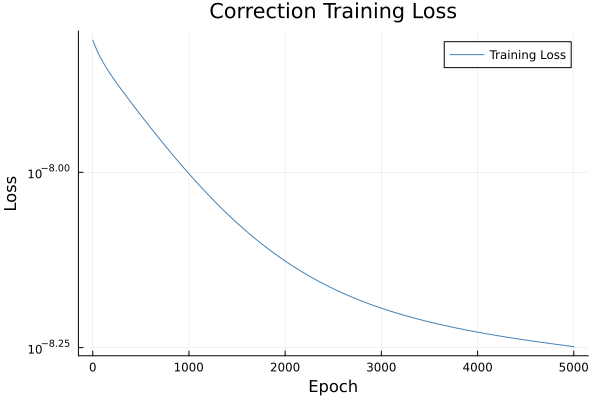

In [18]:
# Plot training and validation losses
p = plot(train_losses_cor, label = "Training Loss", xlabel = "Epoch", ylabel = "Loss", title = "Correction Training Loss", yscale = :log10, color=:steelblue)
savefig(p, joinpath(save_dir, "correction_loss_surrogate$(surrogate)_$(longer).png"))
display(p)

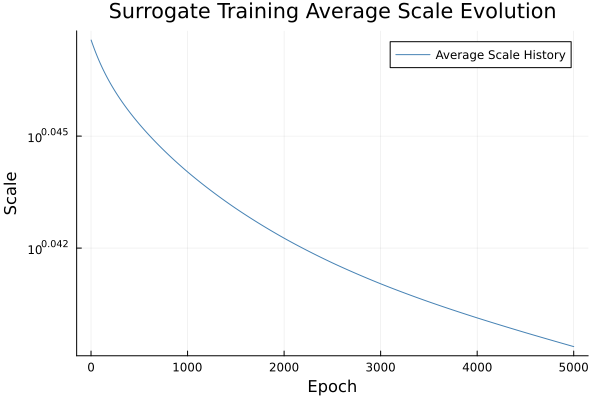

In [19]:
# Plot scale history during training
p = plot(scale_history, label = "Average Scale History", xlabel = "Epoch", ylabel = "Scale", title = "Surrogate Training Average Scale Evolution", yscale = :log10, color=:steelblue)
savefig(p, joinpath(save_dir, "correction_scale_curve.png"))
display(p)

#### Corrected Surrogate Testing

In [20]:
function rollout_surrogate_with_correction(corrective_model, surrogate_model, h0, u0, times, tau_func, amplitude_scale_corr, mu_X, sigma_X, mu_Y, sigma_Y, 
                                           D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, 
                                           complete_input, global_scale, predict_increment; station_indices=[1, 50, 100], init_condition=correction_init_state)
                                         
    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = Float32.(h0)
    u_pred[1,:] = Float32.(u0)

    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Initialize alpha storage for specific stations
    alpha_series = Dict{Int, Vector{Float32}}()
    for idx in station_indices
        alpha_series[idx] = Float32[]
    end

    # Store the exact alpha vectors for all stations
    scale_series = Vector{Vector{Float32}}()

    for k in 1:(length(times) - 1)
        # Step 1 : nominal tau forcing 
        tau_nominal_val = Float32(tau_func(times[k]))     # tau_nominal(t) = [A · sin(2πt/T)]²
        
        # Step 2 - 3 : build normalized correction input with nominal forcing 
        h_current = h_pred[k, :]
        u_current = u_pred[k, :]
    
        corr_input = build_correction_input(h_current, u_current, tau_nominal_val, D_stations, mask, amplitude_scale_corr, n_stations, 
                                          mu_X, sigma_X, norm_cols_corr, mask_cols_corr, complete_input, norm_map_corr; init_condition=init_condition)

        # Step 4 : get correction factor
        alpha_raw = corrective_model(corr_input)  
        alpha = scale_correction(alpha_raw, min=scale_min, max=scale_max)  

        # Step 5 : correct tau at amplitude level 
        if global_scale # one scale correction
            tau_corrected = fill(tau_nominal_val * (alpha^2), n_stations) 
            push!(scale_series, fill(alpha, n_stations))

        else  # scale per-station 
            tau_corrected = tau_nominal_val .* (vec(alpha.^2))
            push!(scale_series, alpha)

            # Save alpha for specific stations 
            for idx in station_indices
                push!(alpha_series[idx], alpha[idx])
            end
        end

        # Step 6 : build surrogate input with corrected tau 
        surrogate_input = Float32[]
        if global_scale
            for i in 1:n_stations
                append!(surrogate_input, [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha]) # α = true scale
            end
        else 
            for i in 1:n_stations
                append!(surrogate_input, [h_current[i], u_current[i], D_stations[i], mask[i], tau_corrected[i], alpha[i]]) # α per station
            end
        end 

        # Add multi_init surrogate input 
        if use_multi_init 
            ic_vec = zeros(Float32, n_init_conditions)
            ic_vec[ic_to_idx[init_condition]] = 1.0f0
            append!(surrogate_input, ic_vec)
        end

        # Normalize inputs
        input_norm = copy(surrogate_input)
        input_norm[norm_cols_X] = (surrogate_input[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = surrogate_input[mask_cols_X]
        input_surr_col = reshape(Float32.(input_norm), :, 1)

        # Surrogate prediction
        pred_norm = surrogate_model(input_surr_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y

        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end
    return h_pred, u_pred, scale_series, alpha_series
end

rollout_surrogate_with_correction (generic function with 1 method)

In [21]:
function rollout_surrogate_with_scale_series(surrogate_model, h0, u0, times, tau_func, scale_series, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, 
                                              n_stations, amplitude_scale; init_condition=correction_init_state)
    
    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1, :] = h0
    u_pred[1, :] = u0
    
    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))
    
    for k in 1:(length(times) - 1)
        # Use the pre-computed alpha vector from scale_series
        current_alpha_vector = scale_series[k]
        tau_val = Float32(tau_func(times[k]))
        input_vec = Float32[]
        
        if global_scale # For global scale, current_alpha_vector contains repeated scalars
            current_alpha = current_alpha_vector[1]
            tau_corrected = tau_val * (current_alpha^2)
            for i in 1:n_stations
                append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_corrected, current_alpha])
            end
        else # For per-station scale, use the exact alpha value for each station
            for i in 1:n_stations
                current_alpha = current_alpha_vector[i]
                tau_corrected_i = tau_val * (current_alpha^2)
                append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_corrected_i, current_alpha])
            end
        end

        # Add multi_init surrogate input 
        if use_multi_init
            ic_vec = zeros(Float32, n_init_conditions)
            ic_vec[ic_to_idx[init_condition]] = 1.0f0
            append!(input_vec, ic_vec)
        end
        
        # Normalize input
        input_norm = copy(input_vec)
        input_norm[norm_cols_X] = (input_vec[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = input_vec[mask_cols_X]
        
        input_col = reshape(Float32.(input_norm), :, 1)
        
        # Surrogate prediction
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y
        
        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end
    return h_pred, u_pred
end

rollout_surrogate_with_scale_series (generic function with 1 method)

In [22]:
# Compute corrected surrogate rollout and post processing rollout with scale series
amplitude_scale_nominal = 1.0f0
#typical_stations = [1, 25, 75, 100] 
typical_stations = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Full correction model
println("\nRunning corrected surrogate rollout...")
H_corrected, U_corrected, scale_series, alpha_series = rollout_surrogate_with_correction(
    corrective_model, surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, amplitude_scale_nominal, mu_X, sigma_X, mu_Y, sigma_Y, 
    D_stations, mask, n_stations, norm_cols_X, mask_cols_X, norm_cols_Y, norm_cols_corr, mask_cols_corr, complete_input, global_scale, predict_increment, 
    station_indices=typical_stations, init_condition=correction_init_state
)

# Run the scale-series surrogate
println("\nRunning scale-series surrogate rollout...")
H_scale_series, U_scale_series = rollout_surrogate_with_scale_series(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, scale_series, 
                                                                     mu_X, sigma_X,mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale_nominal)
nothing


Running corrected surrogate rollout...

Running scale-series surrogate rollout...


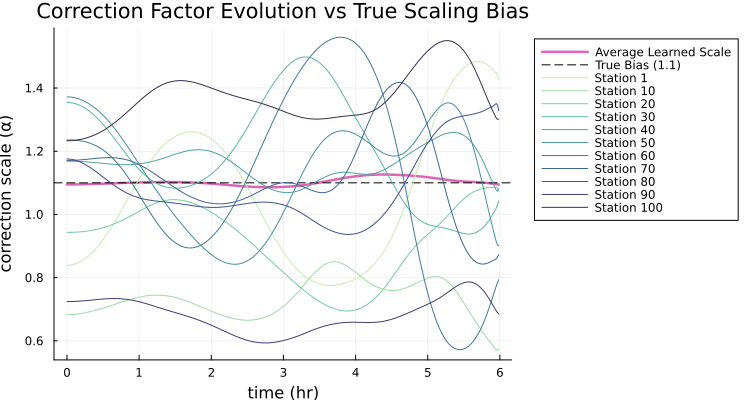

In [23]:
if global_scale
    # For global scale case 
    p = plot(times[1:end-1] ./ 3600, scale_series, label="Global Correction Factor", linewidth=2, color=cur_colors[11])
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=2, color=:black)
    
    xlabel!("Time (hr)"); ylabel!("Correction Scale (α)"); title!("Global Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(save_dir, "global_correction_factor.png"))
    display(p)
else
    # For per-station case
    grad = cgrad(:deep)
    colors = [grad[i] for i in range(0.1, stop=0.9, length=length(typical_stations))]
    labels = ["Station $(s)" for s in typical_stations]
    
    # Compute average scale (mean across stations at each time step)
    avg_scale = [mean(vec(alpha_vec)) for alpha_vec in scale_series]
    p = plot(times[1:end-1] ./ 3600, avg_scale, label="Average Learned Scale", linewidth=2.5, color=cur_colors[end-1], legend=:outertopright, size=(750,400))
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=1, color=:black)
    
    # Plot individual station alphas
    for (i, station_idx) in enumerate(typical_stations)
        if haskey(alpha_series, station_idx) && !isempty(alpha_series[station_idx])
            plot!(p, times[1:end-1] ./ 3600, alpha_series[station_idx], label=labels[i], linewidth=1.0, color=colors[i])
        end
    end
    
    xlabel!(p, "time (hr)"); ylabel!(p, "correction scale (α)"); title!(p, "Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(save_dir, "correction_alpha_bias_surrogate$(surrogate)_$(longer).png"))
    display(p)
end


#### RMSE Tests 

In [24]:
# Compute RMSE per time step (across all stations) - More efficient computation
rmse_nominal_t = [sqrt(mean((H_nominal[t, :] .- H_true[t, :]).^2)) for t in 1:size(H_nominal,1)]
rmse_surrogate_t = [sqrt(mean((H_surrogate[t, :] .- H_true[t, :]).^2)) for t in 1:size(H_surrogate,1)]
rmse_scale_series_t = [sqrt(mean((H_scale_series[t, :] .- H_true[t, :]).^2)) for t in 1:size(H_scale_series,1)]
rmse_corrected_t = [sqrt(mean((H_corrected[t, :] .- H_true[t, :]).^2)) for t in 1:size(H_corrected,1)]

# Global RMSE (across all time & space) - More robust computation
rmse_nominal_global = sqrt(mean((H_nominal .- H_true).^2))
rmse_surrogate_global = sqrt(mean((H_surrogate .- H_true).^2))
rmse_scale_series_global = sqrt(mean((H_scale_series .- H_true).^2))
rmse_corrected_global = sqrt(mean((H_corrected .- H_true).^2))

println("\n📊 RMSE Summary:")

println("\n Global Performance (All Stations & Time)")
println("-"^70)
@printf " Nominal model:        %.6f m (baseline)\n" rmse_nominal_global
@printf " Surrogate:            %.6f m (%+.1f%% vs nominal)\n" rmse_surrogate_global (rmse_surrogate_global/rmse_nominal_global - 1)*100
@printf " Scale-series:         %.6f m (%+.1f%% vs nominal)\n" rmse_scale_series_global (rmse_scale_series_global/rmse_nominal_global - 1)*100
@printf " Corrected (online):   %.6f m (%+.1f%% vs nominal)\n" rmse_corrected_global (rmse_corrected_global/rmse_nominal_global - 1)*100

println("\n Relative Improvements")
println("-"^70)
@printf " Scale-series vs Surrogate:   %+.1f%% improvement\n" (1 - rmse_scale_series_global/rmse_surrogate_global) * 100
@printf " Corrected vs Scale-series:   %+.1f%% improvement\n" (1 - rmse_corrected_global/rmse_scale_series_global) * 100
@printf " Corrected vs Surrogate:      %+.1f%% improvement\n" (1 - rmse_corrected_global/rmse_surrogate_global) * 100


📊 RMSE Summary:

 Global Performance (All Stations & Time)
----------------------------------------------------------------------
 Nominal model:        0.035796 m (baseline)
 Surrogate:            0.042462 m (+18.6% vs nominal)
 Scale-series:         0.009293 m (-74.0% vs nominal)
 Corrected (online):   0.009293 m (-74.0% vs nominal)

 Relative Improvements
----------------------------------------------------------------------
 Scale-series vs Surrogate:   +78.1% improvement
 Corrected vs Scale-series:   +0.0% improvement
 Corrected vs Surrogate:      +78.1% improvement


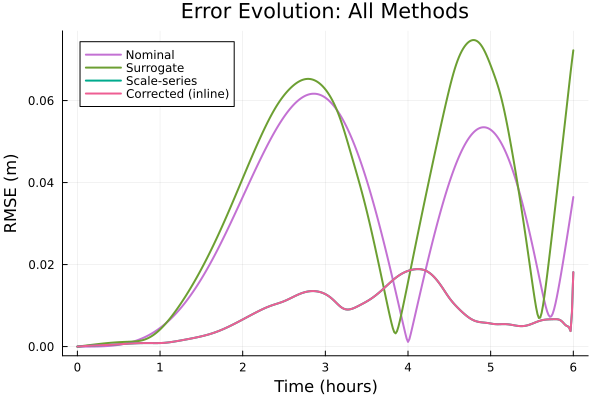

In [25]:
# Enhanced RMSE evolution plot
p_rmse_enhanced = plot(times ./ 3600, rmse_nominal_t, label="Nominal", linewidth=2, color=cur_colors[4])
plot!(times ./ 3600, rmse_surrogate_t, label="Surrogate ", linewidth=2, color=cur_colors[end])
plot!(times ./ 3600, rmse_scale_series_t, label="Scale-series", linewidth=2, color=cur_colors[9])
plot!(times ./ 3600, rmse_corrected_t, label="Corrected (inline)", linewidth=2, color=cur_colors[7])
xlabel!("Time (hours)"); ylabel!("RMSE (m)"); title!("Error Evolution: All Methods")
savefig(p_rmse_enhanced, joinpath(save_dir, "rmse_comparison_enhanced.png"))
display(p_rmse_enhanced)

In [26]:
# RMSE per specific station
println("\n📊 Performance analysis by Station:")
println(" " ^ 70)
rmse_nominal_station = [sqrt(mean((H_nominal[:, s] .- H_true[:, s]).^2)) for s in 1:size(H_nominal,2)]
rmse_surrogate_station = [sqrt(mean((H_surrogate[:, s] .- H_true[:, s]).^2)) for s in 1:size(H_surrogate,2)]
rmse_scale_series_station = [sqrt(mean((H_scale_series[:, s] .- H_true[:, s]).^2)) for s in 1:size(H_scale_series,2)]
rmse_corrected_station = [sqrt(mean((H_corrected[:, s] .- H_true[:, s]).^2)) for s in 1:size(H_corrected,2)]

# Show first, middle, last with enhanced metrics
station_indices = [("First", 1), ("Middle", size(H_nominal,2)÷2), ("Last", size(H_nominal,2))]

for (name, idx) in station_indices
    println("\n  Station $idx ($name):")
    println("    " * "─"^45)
    @printf "    Nominal:     %8.6f m (baseline)\n" rmse_nominal_station[idx]
    @printf "    Surrogate:   %8.6f m (%+6.1f%% vs nominal)\n" rmse_surrogate_station[idx] (rmse_surrogate_station[idx]/rmse_nominal_station[idx] - 1)*100
    @printf "    Scale-ser.:  %8.6f m (%+6.1f%% vs nominal)\n" rmse_scale_series_station[idx] (rmse_scale_series_station[idx]/rmse_nominal_station[idx] - 1)*100
    @printf "    Corrected:   %8.6f m (%+6.1f%% vs nominal)\n" rmse_corrected_station[idx] (rmse_corrected_station[idx]/rmse_nominal_station[idx] - 1)*100
    
    # Additional comparisons
    improv_vs_surrogate = (1 - rmse_corrected_station[idx]/rmse_surrogate_station[idx])*100
    improv_vs_scale_series = (1 - rmse_corrected_station[idx]/rmse_scale_series_station[idx])*100
    @printf "    → Corrected improves: %+5.1f%% vs surrogate, %+5.1f%% vs scale-series\n" improv_vs_surrogate improv_vs_scale_series
end

nothing


📊 Performance analysis by Station:
                                                                      

  Station 1 (First):
    ─────────────────────────────────────────────
    Nominal:     0.064781 m (baseline)
    Surrogate:   0.078438 m ( +21.1% vs nominal)
    Scale-ser.:  0.014895 m ( -77.0% vs nominal)
    Corrected:   0.014895 m ( -77.0% vs nominal)
    → Corrected improves: +81.0% vs surrogate,  +0.0% vs scale-series

  Station 50 (Middle):
    ─────────────────────────────────────────────
    Nominal:     0.002685 m (baseline)
    Surrogate:   0.003155 m ( +17.5% vs nominal)
    Scale-ser.:  0.000946 m ( -64.8% vs nominal)
    Corrected:   0.000946 m ( -64.8% vs nominal)
    → Corrected improves: +70.0% vs surrogate,  +0.0% vs scale-series

  Station 100 (Last):
    ─────────────────────────────────────────────
    Nominal:     0.059614 m (baseline)
    Surrogate:   0.070160 m ( +17.7% vs nominal)
    Scale-ser.:  0.014646 m ( -75.4% vs nominal)
    Corrected:   0.014646

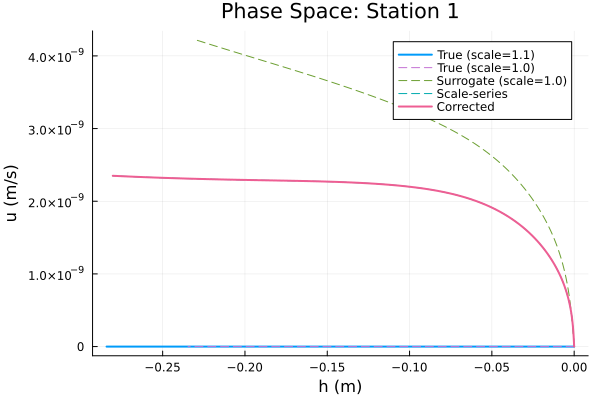

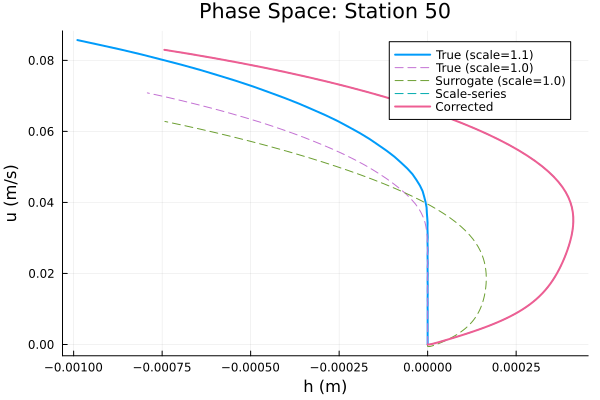

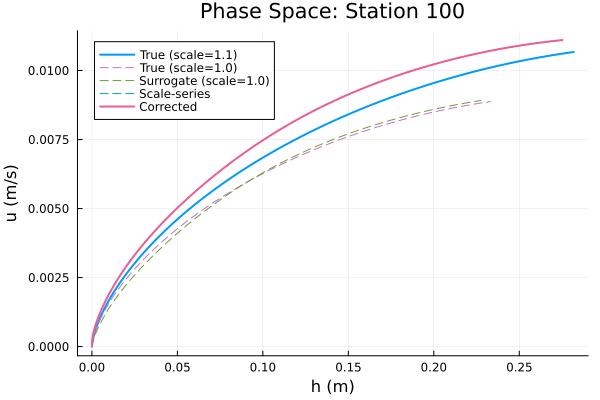

In [27]:
# Phase space plot (h vs u) for different methods
function plot_phase_space(station_idx, time_range=1:100)
    p_phase = plot(size=(600, 400), xlabel="h (m)", ylabel="u (m/s)", title="Phase Space: Station $station_idx") #, legend=:topright)
    
    # data
    plot!(H_true[time_range, station_idx], U_true[time_range, station_idx], label="True (scale=$bias_factor)", linewidth=2)
    plot!(H_nominal[time_range, station_idx], U_nominal[time_range, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
    plot!(H_surrogate[time_range, station_idx], U_surrogate[time_range, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
    plot!(H_scale_series[time_range, station_idx], U_scale_series[time_range, station_idx], label="Scale-series", color=cur_colors[6], linestyle=:dash)
    plot!(H_corrected[time_range, station_idx], U_corrected[time_range, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
    
    display(p_phase)
    return p_phase
end

# Plot for your typical stations
for station in [1, 50, 100]
    plot_phase_space(station)
    #savefig("phase_space_station_$station.png")
end

In [28]:
# Create a comprehensive performance table
methods = ["Nominal", "Surrogate", "Scale-series", "Corrected (online)"]
rmse_values = [rmse_nominal_global, rmse_surrogate_global, rmse_scale_series_global, rmse_corrected_global]
improvement_vs_nominal = [0.0, 
                         (1 - rmse_surrogate_global/rmse_nominal_global) * 100,
                         (1 - rmse_scale_series_global/rmse_nominal_global) * 100,
                         (1 - rmse_corrected_global/rmse_nominal_global) * 100]

println("\n Performance Summary Table:")
println("="^65)
println(" Method              | RMSE (m)   | Improvement vs Nominal")
println("-"^65)
for i in 1:length(methods)
    @printf " %-18s | %-10.6f | %6.1f%%\n" methods[i] rmse_values[i] improvement_vs_nominal[i]
end


 Performance Summary Table:
 Method              | RMSE (m)   | Improvement vs Nominal
-----------------------------------------------------------------
 Nominal            | 0.035796   |    0.0%
 Surrogate          | 0.042462   |  -18.6%
 Scale-series       | 0.009293   |   74.0%
 Corrected (online) | 0.009293   |   74.0%


#### Correction Model Saving

In [29]:
# Save model
model_file = joinpath(save_dir, "corrective_model.bson")
BSON.@save model_file corrective_model

# Save training metrics
metrics_file = joinpath(save_dir, "training_metrics.jld2")
@save metrics_file train_losses_cor scale_history n_epochs_corr learning_rate

println("✓ Saved to: $save_dir")

# Compute RMSE metrics for corrected predictions
rmse_nominal = sqrt(mean((H_nominal .- H_true).^2))
rmse_surrogate = sqrt(mean((H_surrogate .- H_true).^2))
rmse_corrected = sqrt(mean((H_corrected .- H_true).^2))

# Compute per-time and per-station statistics
rmse_corrected_time = [sqrt(mean((H_corrected[t,:] .- H_true[t,:]).^2)) for t in 1:size(H_corrected,1)]
rmse_corrected_station = [sqrt(mean((H_corrected[:,s] .- H_true[:,s]).^2)) for s in 1:n_stations]

# Compute velocity errors
rmse_u_nominal = sqrt(mean((U_nominal .- U_true).^2))
rmse_u_corrected = sqrt(mean((U_corrected .- U_true).^2))

# Compute improvement percentages
improvement_nominal_pct = (rmse_nominal - rmse_corrected) / rmse_nominal * 100
improvement_surrogate_pct = (rmse_surrogate - rmse_corrected) / rmse_surrogate * 100


stats_dict = Dict(
    # RMSE metrics
    "rmse_nominal" => rmse_nominal,
    "rmse_surrogate" => rmse_surrogate,
    "rmse_corrected" => rmse_corrected,
    "rmse_corrected_time" => rmse_corrected_time,
    "rmse_corrected_station" => rmse_corrected_station,
    "rmse_u_nominal" => rmse_u_nominal,
    "rmse_u_corrected" => rmse_u_corrected,
    
    # Improvement metrics
    "improvement_nominal_pct" => improvement_nominal_pct,
    "improvement_surrogate_pct" => improvement_surrogate_pct,
    
    # Predictions
    "H_corrected" => H_corrected,
    "U_corrected" => U_corrected,
    "H_nominal" => H_nominal,
    "U_nominal" => U_nominal,
    "H_true" => H_true,
    "U_true" => U_true,
    "H_surrogate" => H_surrogate,
    "U_surrogate" => U_surrogate,
    
    # Correction factors
    "scale_series" => scale_series,
    "alpha_series" => alpha_series,
    
    # Configuration
    "global_scale" => global_scale,
    "complete_input" => complete_input,
    "predict_scale_increment" => predict_scale_increment,
    "predict_increment" => predict_increment,
    "use_multi_data" => use_multi_data,
    "use_multi_init" => use_multi_init,
    
    # Training info
    "n_epochs_corr" => n_epochs_corr,
    "learning_rate" => learning_rate,
    "K_global" => K_global,
    "bias_factor" => bias_factor,
    "wind_name" => wind_name,
    "correction_init_state" => correction_init_state,
    "surrogate" => surrogate,
    "SEED" => SEED
)

stats_file = joinpath(save_dir, "correction_statistics.jld2")
@save stats_file stats_dict
println("✓ Statistics saved to: $stats_file")

✓ Saved to: surrogates/surrogate_2/correction_1)
✓ Statistics saved to: surrogates/surrogate_2/correction_1)/correction_statistics.jld2


#### Corrected Surrogate Time Series Comparison

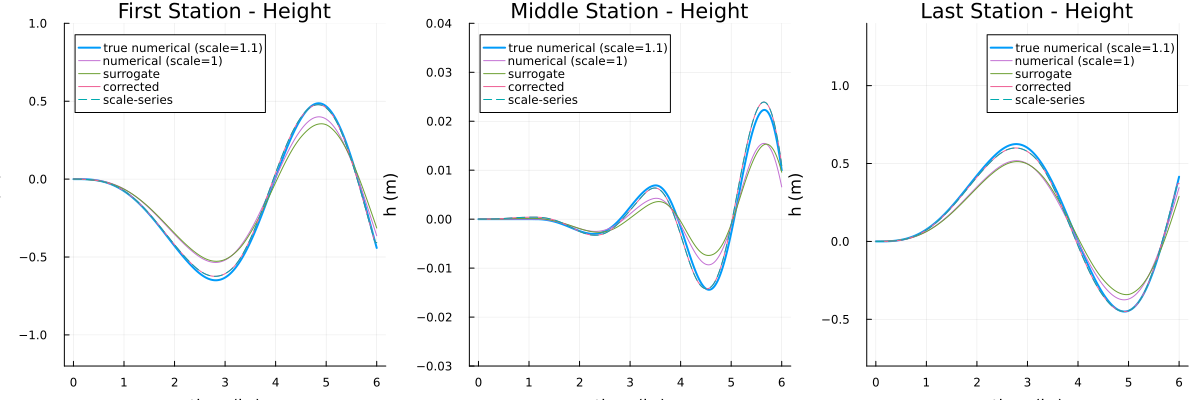

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/surrogate_2/correction_1)/flat_correction_rollout1_surrogate2_false.png"

In [30]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["First Station - Height", "Middle Station - Height", "Last Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
    plot!(plt[i], times ./ 3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
    plot!(plt[i], times ./ 3600, H_scale_series[:, s], label="scale-series", color=cur_colors[6], linestyle=:dash)
    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

# Optionally save the figure
display(plt)
savefig(plt, joinpath(save_dir, "$(correction_init_state)_correction_rollout1_surrogate$(surrogate)_$(longer).png"))

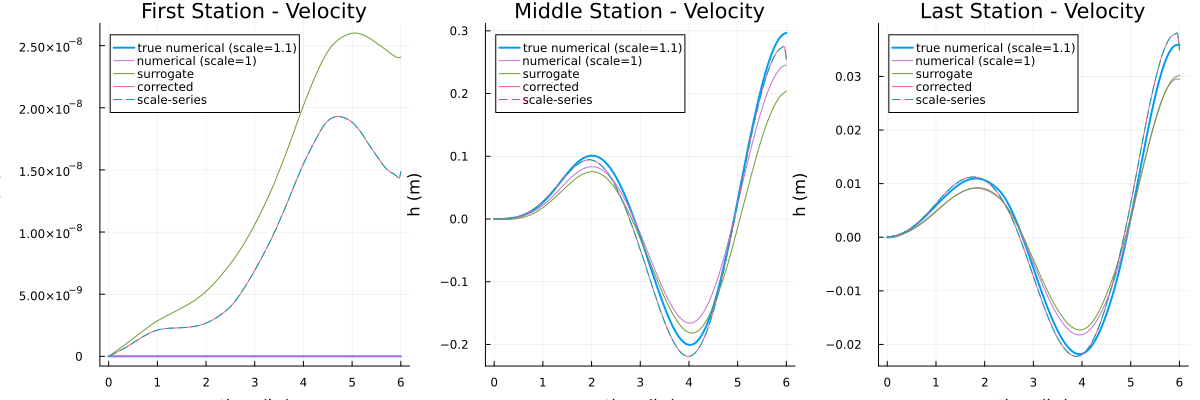

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/surrogate_2/correction_1)/flat_correction_velocity_surrogate2_false.png"

In [31]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
titles = ["First Station - Velocity", "Middle Station - Velocity", "Last Station - Velocity"]

plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, U_true[:, s], label="true numerical (scale=$bias_factor)", lw=2)
    plot!(plt[i], times ./ 3600, U_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, U_surrogate[:, s], label="surrogate", color=cur_colors[end])
    plot!(plt[i], times ./ 3600, U_corrected[:, s], label="corrected", color=cur_colors[7])
    plot!(plt[i], times ./ 3600, U_scale_series[:, s], label="scale-series", color=cur_colors[6], linestyle=:dash)

    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

display(plt)
savefig(plt, joinpath(save_dir, "$(correction_init_state)_correction_velocity_surrogate$(surrogate)_$(longer).png"))

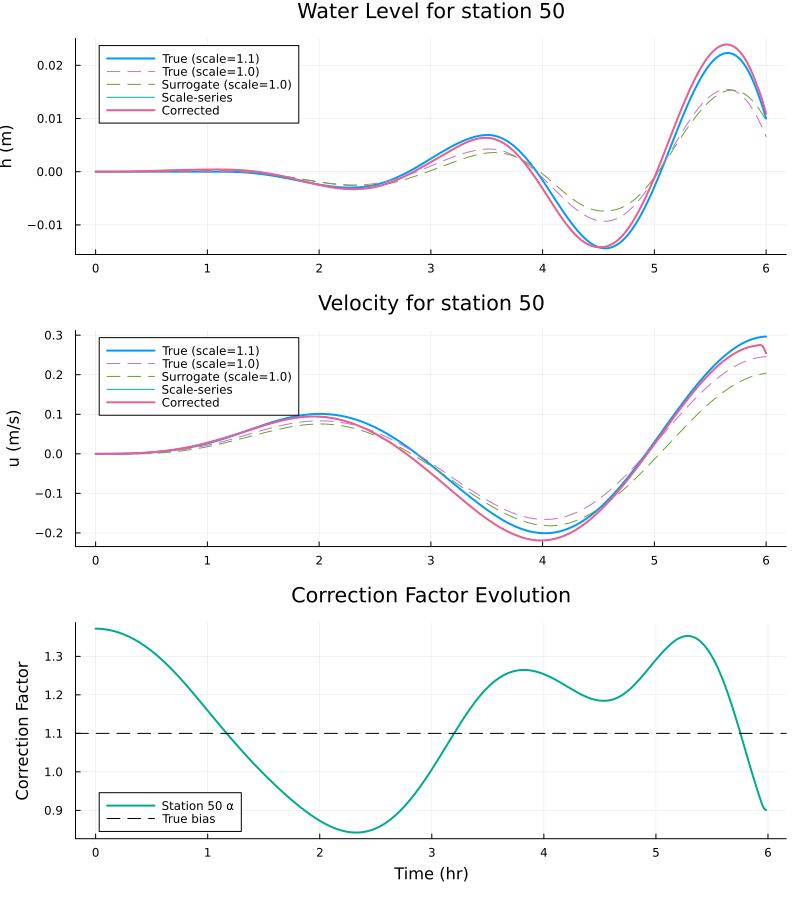

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/surrogate_2/correction_1)/flat_diagnostic_panel_station_50_surrogate2_false.png"

In [32]:
# Multi-panel diagnostic plot for a representative station
station_idx = 50  # middle station
p_diagnostic = plot(layout=(3,1), size=(800, 900))

# Panel 1: Water level comparison
plot!(p_diagnostic[1], times./3600, H_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[1], times./3600, H_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[1], times./3600, H_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[1], "h (m)"); title!(p_diagnostic[1], "Water Level for station $station_idx")


# Panel 2: Velocity comparison
plot!(p_diagnostic[2], times./3600, U_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[2], times./3600, U_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[2], times./3600, U_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[2], "u (m/s)"); title!(p_diagnostic[2], "Velocity for station $station_idx")

# Panel 3: Correction factor evolution
if !global_scale
    plot!(p_diagnostic[3], times[1:end-1]./3600, alpha_series[station_idx], label="Station $station_idx α", linewidth=2, color=cur_colors[9])
else
    plot!(p_diagnostic[3], times[1:end-1]./3600, scale_series, label="Global α", linewidth=2, color=cur_colors[9])
end
hline!(p_diagnostic[3], [bias_factor], label="True bias", ls=:dash, color=:black)
xlabel!(p_diagnostic[3], "Time (hr)"); ylabel!(p_diagnostic[3], "Correction Factor"); title!(p_diagnostic[3], "Correction Factor Evolution")

display(p_diagnostic)
savefig(p_diagnostic, joinpath(save_dir, "$(correction_init_state)_diagnostic_panel_station_$(station_idx)_surrogate$(surrogate)_$(longer).png"))

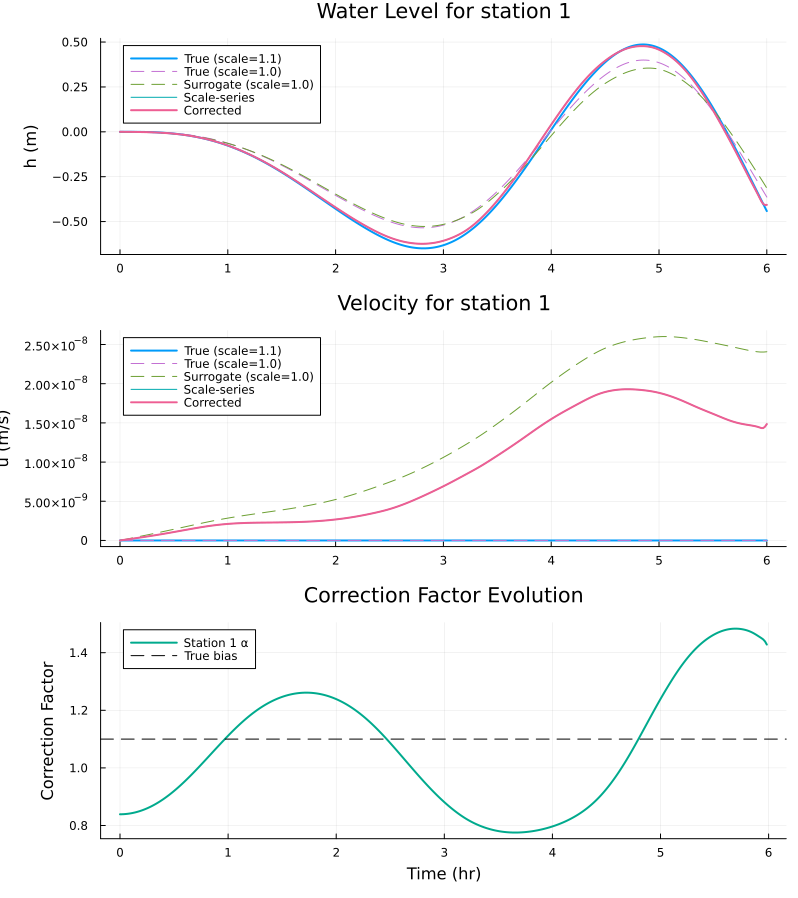

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/surrogate_2/correction_1)/flat_diagnostic_panel_station_1_surrogate2_false.png"

In [33]:
# Multi-panel diagnostic plot for a representative station
station_idx = 1 # first station
p_diagnostic = plot(layout=(3,1), size=(800, 900))

# Panel 1: Water level comparison
plot!(p_diagnostic[1], times./3600, H_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[1], times./3600, H_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[1], times./3600, H_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[1], "h (m)"); title!(p_diagnostic[1], "Water Level for station $station_idx")


# Panel 2: Velocity comparison
plot!(p_diagnostic[2], times./3600, U_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[2], times./3600, U_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[2], times./3600, U_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[2], "u (m/s)"); title!(p_diagnostic[2], "Velocity for station $station_idx")

# Panel 3: Correction factor evolution
if !global_scale
    plot!(p_diagnostic[3], times[1:end-1]./3600, alpha_series[station_idx], label="Station $station_idx α", linewidth=2, color=cur_colors[9])
else
    plot!(p_diagnostic[3], times[1:end-1]./3600, scale_series, label="Global α", linewidth=2, color=cur_colors[9])
end
hline!(p_diagnostic[3], [bias_factor], label="True bias", ls=:dash, color=:black)
xlabel!(p_diagnostic[3], "Time (hr)"); ylabel!(p_diagnostic[3], "Correction Factor"); title!(p_diagnostic[3], "Correction Factor Evolution")

display(p_diagnostic)
savefig(p_diagnostic, joinpath(save_dir, "$(correction_init_state)_diagnostic_panel_station_$(station_idx)_surrogate$(surrogate)_$(longer).png"))

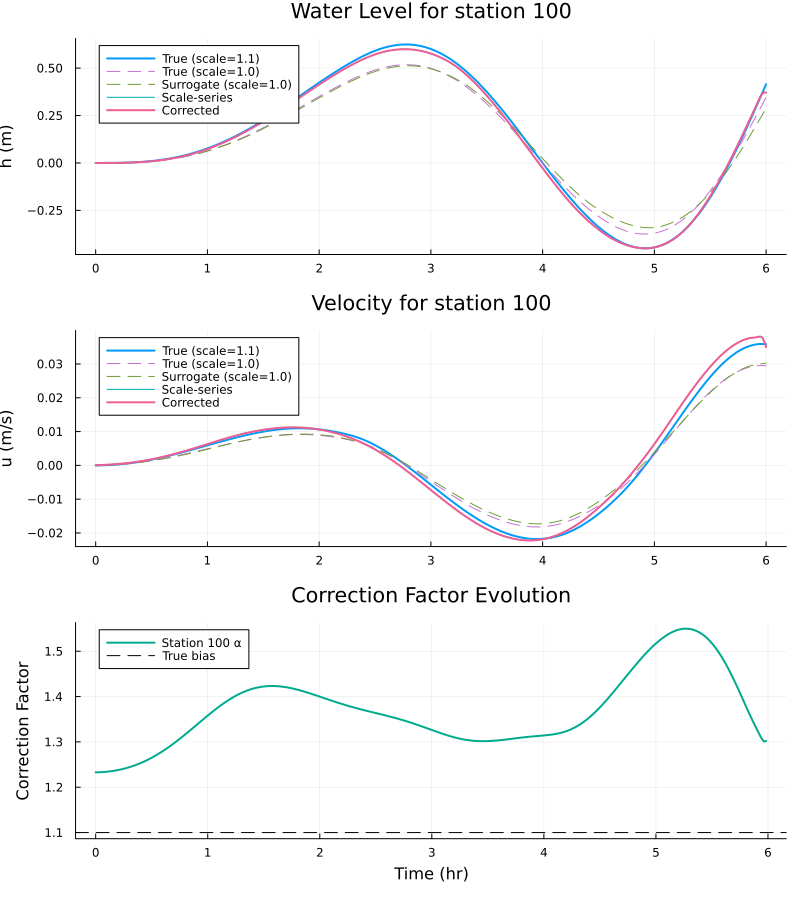

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/surrogate_2/correction_1)/flat_diagnostic_panel_station_100_surrogate2_false.png"

In [34]:
# Multi-panel diagnostic plot for a representative station
station_idx = 100  # last station
p_diagnostic = plot(layout=(3,1), size=(800, 900))

# Panel 1: Water level comparison
plot!(p_diagnostic[1], times./3600, H_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[1], times./3600, H_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[1], times./3600, H_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[1], times./3600, H_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[1], "h (m)"); title!(p_diagnostic[1], "Water Level for station $station_idx")


# Panel 2: Velocity comparison
plot!(p_diagnostic[2], times./3600, U_true[:, station_idx], label="True (scale=$bias_factor)", linewidth=2)
plot!(p_diagnostic[2], times./3600, U_nominal[:, station_idx], label="True (scale=1.0)", color=cur_colors[4], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_surrogate[:, station_idx], label="Surrogate (scale=1.0)", color=cur_colors[end], linestyle=:dash)
plot!(p_diagnostic[2], times./3600, U_scale_series[:, station_idx], label="Scale-series", color=cur_colors[6])
plot!(p_diagnostic[2], times./3600, U_corrected[:, station_idx], label="Corrected", color=cur_colors[7], linewidth=2)
ylabel!(p_diagnostic[2], "u (m/s)"); title!(p_diagnostic[2], "Velocity for station $station_idx")

# Panel 3: Correction factor evolution
if !global_scale
    plot!(p_diagnostic[3], times[1:end-1]./3600, alpha_series[station_idx], label="Station $station_idx α", linewidth=2, color=cur_colors[9])
else
    plot!(p_diagnostic[3], times[1:end-1]./3600, scale_series, label="Global α", linewidth=2, color=cur_colors[9])
end
hline!(p_diagnostic[3], [bias_factor], label="True bias", ls=:dash, color=:black)
xlabel!(p_diagnostic[3], "Time (hr)"); ylabel!(p_diagnostic[3], "Correction Factor"); title!(p_diagnostic[3], "Correction Factor Evolution")

display(p_diagnostic)
savefig(p_diagnostic, joinpath(save_dir, "$(correction_init_state)_diagnostic_panel_station_$(station_idx)_surrogate$(surrogate)_$(longer).png"))

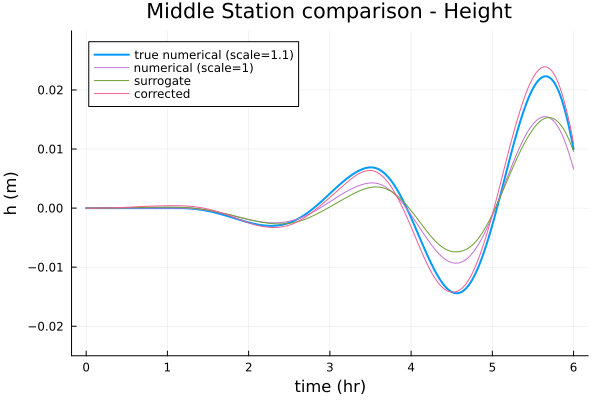

In [35]:
# Rollout comparison at a station s
s = station_idxs[end ÷ 2]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-0.025, 0.03))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Middle Station comparison - Height")
savefig(p, joinpath(save_dir, "middletation_surrogate$(surrogate)_$(longer).png"))
display(p)

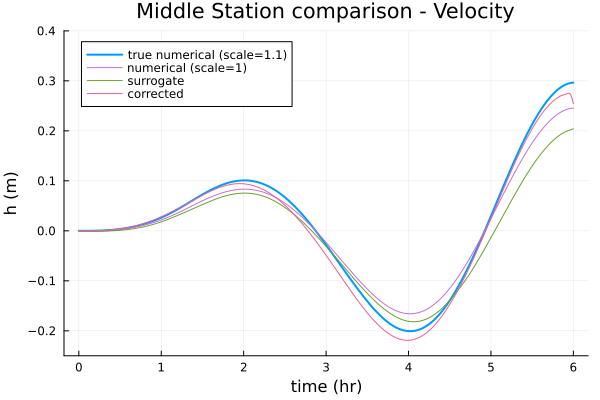

In [36]:
# Rollout comparison at a station s
p = plot(times./3600, U_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-0.25, 0.4))
plot!(times./3600, U_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, U_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, U_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Middle Station comparison - Velocity")
savefig(p, joinpath(save_dir, "middletation_velocity_surrogate$(surrogate)_$(longer).png"))
display(p)

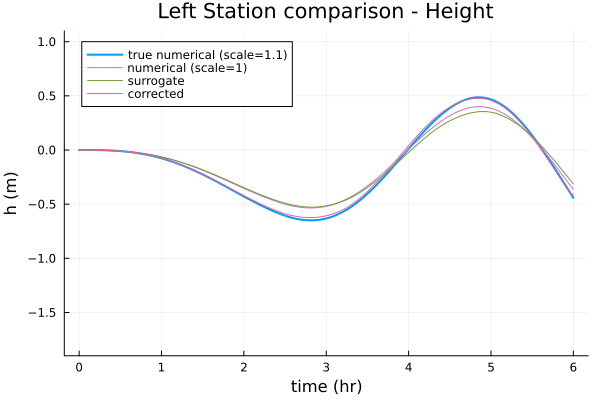

In [37]:
# Rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-1.9, 1.1)) # ylim=(-0.8, 0.55))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Left Station comparison - Height")
savefig(p, joinpath(save_dir, "firststation_surrogate$(surrogate)_$(longer).png"))
display(p)

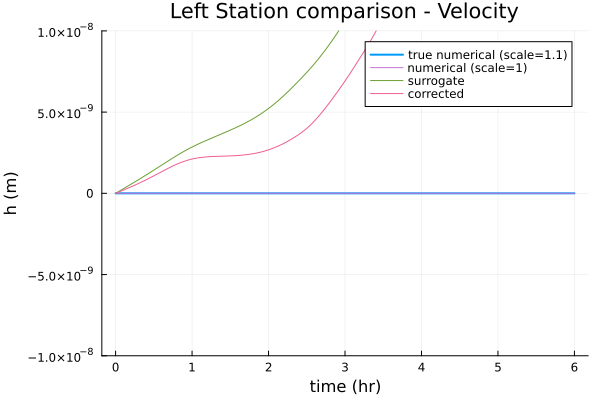

In [38]:
# Rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, U_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-1e-8, 1e-8))
plot!(times./3600, U_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, U_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, U_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Left Station comparison - Velocity")
savefig(p, joinpath(save_dir, "firststation_velocity_surrogate$(surrogate)_$(longer).png"))
display(p)

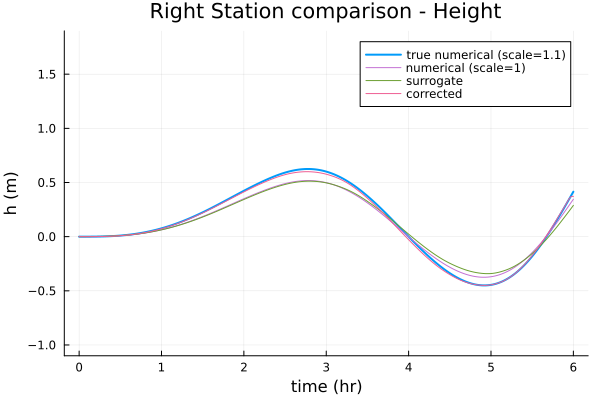

In [39]:
# Rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-1.1, 1.9)) # ylim=(-0.55, 0.8))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Right Station comparison - Height")
savefig(p, joinpath(save_dir, "finalstation_surrogate$(surrogate)_$(longer).png"))
display(p)

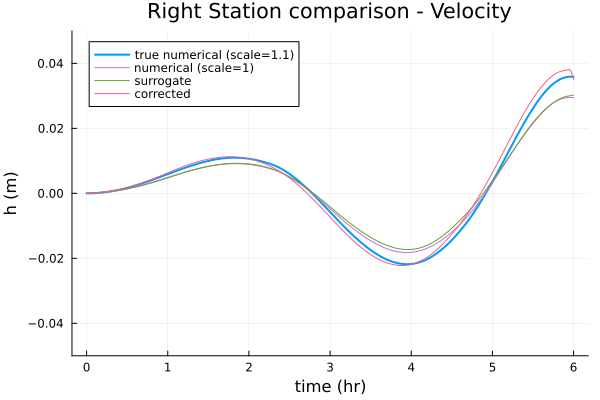

In [40]:
# Rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, U_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=(-0.05, 0.05))
plot!(times./3600, U_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, U_surrogate[:, s], label="surrogate", color=cur_colors[end])
plot!(times./3600, U_corrected[:, s], label="corrected", color=cur_colors[7])
xlabel!("time (hr)"); ylabel!("h (m)"); title!("Right Station comparison - Velocity")
savefig(p, joinpath(save_dir, "finalstation_velocity_surrogate$(surrogate)_$(longer).png"))
display(p)

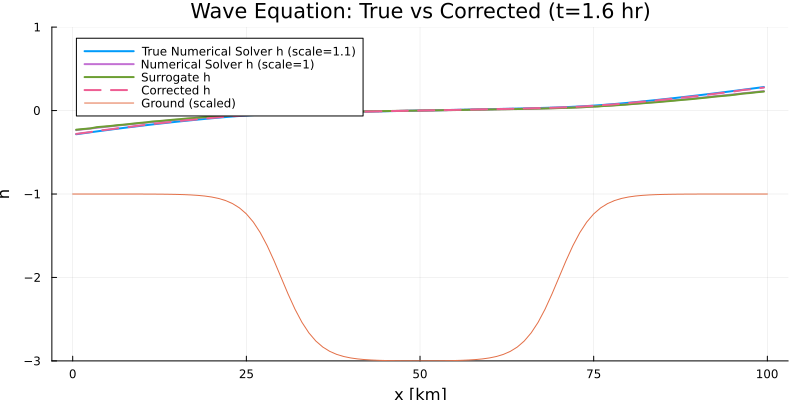

In [41]:
# Snapshot comparison at a time i
i = 100
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical Solver h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_h, H_corrected[i, :], label="Corrected h", linestyle=:dash, lw=2, color=cur_colors[7])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Corrected (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

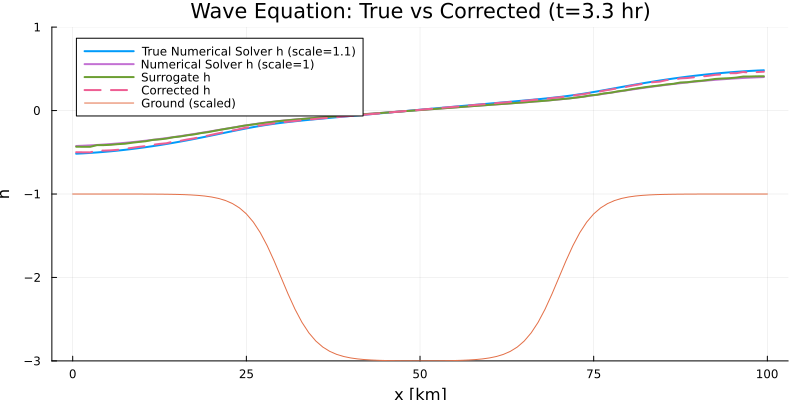

In [42]:
# Snapshot comparison at a time i
i = 200
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical Solver h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_h, H_corrected[i, :], label="Corrected h", linestyle=:dash, lw=2, color=cur_colors[7])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Corrected (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

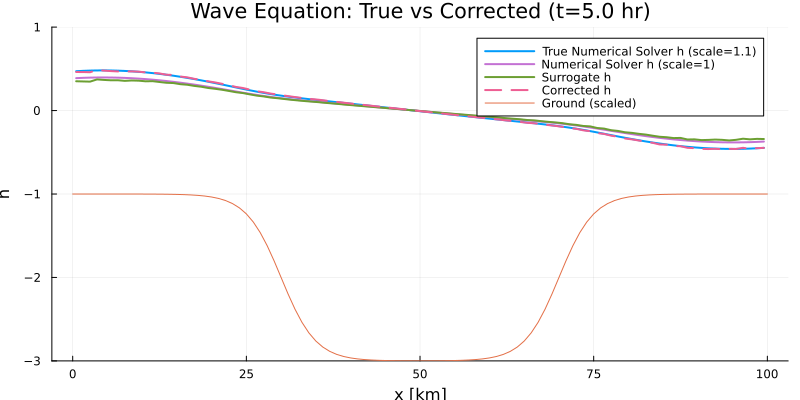

In [43]:
# Snapshot comparison at a time i
i = 300
p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical Solver h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
plot!(1e-3 * x_h, sol_nominal[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h", linestyle=:solid, lw=2, color=cur_colors[end])
plot!(1e-3 * x_h, H_corrected[i, :], label="Corrected h", linestyle=:dash, lw=2, color=cur_colors[7])
plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
plot!(p, size=(800,400), title="Wave Equation: True vs Corrected (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
display(p)

┌ Info: Saved animation to /Users/sara/Desktop/Deltares/Final Report Code/Model-2/gif/flat_wave1d_corrected_comparison.gif
└ @ Plots /Users/sara/.julia/packages/Plots/ywg93/src/animation.jl:156


 12.743238 seconds (7.57 M allocations: 290.496 MiB, 4.76% gc time, 3.07% compilation time: 24% of which was recompilation)


Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Final Report Code/Model-2/gif/flat_wave1d_corrected_comparison.gif")
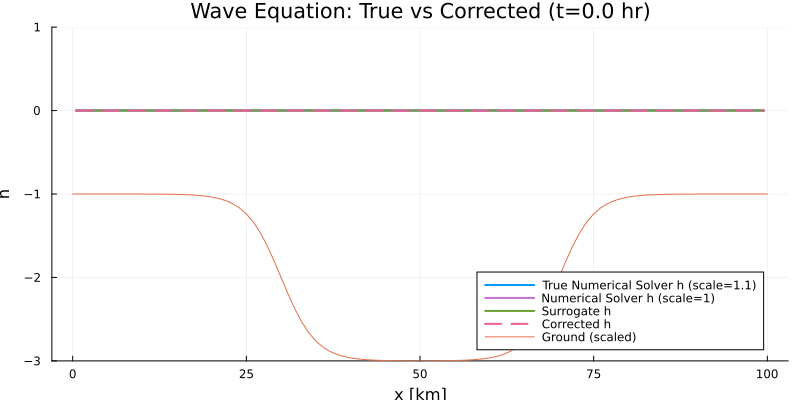

In [44]:
@time begin
    anim = @animate for i in 1:length(sol_true.t)
        p = plot(1e-3 * x_h, sol_true[i].h, label="True Numerical Solver h (scale=$bias_factor)", xlabel="x [km]", ylabel="h", ylim=(-3, 1), lw=2)
        plot!(1e-3 * x_h, sol_nominal[i].h, label="Numerical Solver h (scale=1)", linestyle=:solid, lw=2, color=cur_colors[4])
        plot!(1e-3 * x_h, H_surrogate[i, :], label="Surrogate h", linestyle=:solid, lw=2, color=cur_colors[end])
        plot!(1e-3 * x_h, H_corrected[i, :], label="Corrected h", linestyle=:dash, lw=2, color=cur_colors[7])
        plot!(1e-3 * x_u, -0.1 * D, label="Ground (scaled)", lw=1, color=cur_colors[2])
        plot!(p, size=(800,400), title="Wave Equation: True vs Corrected (t=$(round(sol_true.t[i]/3600, digits=1)) hr)")
    end
    gif(anim, "gif/$(correction_init_state)_wave1d_corrected_comparison.gif", fps=30)
end